In [1]:
import pandas as pd
import numpy as np
import datetime
import time 
import os
import gc


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
'''/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)'''

'/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead\n  return getattr(obj, method)(*args, **kwds)'

In [3]:
data_path = './data/'
!ls -lthr data/

total 5771360
-rw-------@ 1 sam_dessa  staff   246M 24 Mar 18:29 item_metadata.csv
-rw-------@ 1 sam_dessa  staff   510M 24 Mar 18:29 test.csv
-rw-------@ 1 sam_dessa  staff   2.0G 24 Mar 18:29 train.csv
-rw-------@ 1 sam_dessa  staff    51M 24 Mar 18:48 submission_popular.csv


In [4]:
%%time
# nrows = 100000
nrows = None
train = pd.read_csv(data_path+'train.csv', nrows=nrows)

CPU times: user 20.5 s, sys: 1.48 s, total: 22 s
Wall time: 22 s


In [5]:
def pshape(df):
    print(f'df len: {df.shape[0]:,}')

In [6]:
pshape(train)

df len: 15,932,992


In [7]:
test = pd.read_csv(data_path+'test.csv', nrows=1000)
test.shape

(1000, 12)

In [8]:
train.head(2)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


In [9]:
# test_click_session_ids = test[test.impressions.notnull()].session_id.unique()

In [10]:
# ts = np.random.choice(test_click_session_ids, 1)
# test[test.session_id==ts[0]]

In [11]:
# train_click_ids = train[train.impressions.notnull()].session_id.unique()

In [12]:
# ts = np.random.choice(train_click_ids, 1)
# train[train.session_id==ts[0]]

In [13]:
# train.groupby('session_id').apply(lambda x: x.iloc[-1]['reference']).isna().sum()

In [14]:
# train.groupby('session_id').apply(lambda x: x.iloc[-1]['impressions']).isna().sum()

### clip sessions off to last click

In [15]:
%%time
# get all rows upto the last clickout action (some rows has reference but it's not clickout action)
def up_to_last_click(grp):
    check = grp.action_type == 'clickout item'
    if check.sum() != 0:
        return grp.iloc[:np.argwhere(check)[-1][0]+1]
    else:
        return grp
        
train = train.groupby('session_id').apply(up_to_last_click).reset_index(drop=True)

CPU times: user 9min 33s, sys: 7.64 s, total: 9min 40s
Wall time: 9min 40s


In [16]:
%%time
# get utc timestamp
train['ts'] = train['timestamp'].apply(lambda t: datetime.datetime.utcfromtimestamp(t))

CPU times: user 6.58 s, sys: 290 ms, total: 6.87 s
Wall time: 6.87 s


In [17]:
%%time
# only look at sessions with clickouts (for now)
# first filter out sessions that does not have a click-out
def check_clickout(grp):
     # sessions has clickouts
    has_clickout = 'clickout item' in grp['action_type'].unique()
    # last row has reference and it's not nan
    has_ref = ((grp['action_type'].iloc[-1] == 'clickout item') & 
               (grp.iloc[-1][['impressions', 'reference', 'prices']].isna().sum()==0))
    return has_clickout & has_ref
    
clicked = train.groupby('session_id').apply(check_clickout)
click_session_ids = clicked[clicked].index
# filter
train = train[train.session_id.isin(click_session_ids)].reset_index(drop=True)

CPU times: user 14min 52s, sys: 11.9 s, total: 15min 4s
Wall time: 15min 4s


In [18]:
# %%time
# # only look at sessions with clickouts (for now)
# # first filter out sessions that does not have a click-out
# def check_clickout(grp):
#      # sessions has clickouts
#     has_clickout = 'clickout item' in grp['action_type'].unique()
#     # last row has reference and it's not nan
#     has_ref = ((grp['action_type'].iloc[-1] == 'clickout item') & 
#                (pd.notnull(grp.iloc[-1]['impressions'])) &
#                (pd.notnull(grp.iloc[-1]['reference'])) &
#                (pd.notnull(grp.iloc[-1]['prices'])))
#     return has_clickout & has_ref
    
# clicked = train.groupby('session_id').apply(check_clickout)
# click_session_ids = clicked[clicked].index
# # filter
# train = train[train.session_id.isin(click_session_ids)].reset_index(drop=True)

In [19]:
pshape(train)

df len: 11,367,205


In [20]:
# d = train.groupby('session_id')
# for i, j in d:
#     print(j.head())
#     print('='*20)
#      # sessions has clickouts
#     has_clickout = 'clickout item' in j['action_type'].unique()
#     print(has_clickout)
#     # last row has reference and it's not nan
#     has_ref = ((j['action_type'].iloc[-1] == 'clickout item') & 
#                (pd.notnull(j.iloc[-1]['impressions'])) &
#                (pd.notnull(j.iloc[-1]['reference'])))
#     print(has_ref)
#     break

### meta info

In [21]:
%%time
meta = pd.read_csv(data_path+'item_metadata.csv', nrows=nrows)
meta['properties'] = meta['properties'].str.lower()

CPU times: user 2.44 s, sys: 191 ms, total: 2.63 s
Wall time: 2.63 s


In [22]:
%%time
# checkout properties of items
def get_property_count(row):
    return len(row.split('|'))

item_p_ctn = meta['properties'].apply(get_property_count)
item_p_ctn.describe()

CPU times: user 1.36 s, sys: 14.7 ms, total: 1.38 s
Wall time: 1.38 s


In [23]:
%%time
def get_property(row):
    return row.lower().split('|')
meta['ps'] = meta['properties'].apply(get_property)
# numer of properties
meta['nprop'] = meta.ps.str.len()
# star ratings
meta['star'] = meta.properties.str.extract('[\|](\d) star')
meta['star'] = meta['star'].astype(float)

CPU times: user 3.99 s, sys: 319 ms, total: 4.31 s
Wall time: 4.31 s


In [24]:
%%time
# create rating columns
ratings = ['good rating', 'satisfactory rating', 'excellent rating']
for r in ratings:
    meta[r.replace(' ', '_')] = meta.properties.str.findall(f'\|{r}').str.len()

CPU times: user 6.84 s, sys: 110 ms, total: 6.95 s
Wall time: 6.94 s


In [25]:
def get_popularity(df):
    """Get number of clicks that each item received in the df."""

    mask = df["action_type"] == "clickout item"
    df_clicks = df[mask]
    df_item_clicks = (df_clicks
                      .groupby("reference")
                      .size()
                      .reset_index(name="n_clicks")
                      .transform(lambda x: x.astype(int)))
    return df_item_clicks

In [26]:
%%time
item_popularity = get_popularity(train)
meta = pd.merge(meta, item_popularity, left_on='item_id', right_on='reference')

CPU times: user 2.67 s, sys: 168 ms, total: 2.83 s
Wall time: 2.84 s


In [27]:
meta = (meta[['item_id', 'nprop', 'n_clicks', 'star', 'good_rating', 'satisfactory_rating', 'excellent_rating']]
        .set_index('item_id'))

### Create session features
---

In [28]:
# %%time
# # find out if same customers have multiple sessions
# s = train.drop_duplicates(subset=['user_id', 'session_id'])
# s.session_id.duplicated().sum()
# # seems like not

In [29]:
# train.current_filters[:1000].unique()

In [30]:
%%time
def get_filters(x):
    if type(x) == str or type(x) == list:
        return x.split('|')
    else:
        return np.nan
def get_impressions(x):
    if type(x) == str:
        return x.split('|')
    else:
        return np.nan
    
    
train['filters'] = train.current_filters.str.split('|')
train['nfilters'] = train.filters.str.len()
train['imps_list'] = train.impressions.str.split('|')
nn_mask = train['imps_list'].notnull()
train.loc[nn_mask, 'imps_list'] = train.loc[nn_mask, 'imps_list'].apply(lambda x: [int(i) for i in x])
train['nimps'] = train.imps_list.str.len()

CPU times: user 21.9 s, sys: 2.04 s, total: 23.9 s
Wall time: 23.9 s


In [31]:
# train.nimps.describe()

In [32]:
# # no switch of devices during session
# (train.groupby('session_id')['device'].nunique()!=1).sum()

In [33]:
# # differnet city during session
# (train.groupby('session_id')['city'].nunique()!=1).sum()

In [34]:
%%time
# some custom funcs used in agggregation
def mean_dwell_time(x):
    if len(x) == 1:
        return 0
    else:
        return np.mean(np.diff(np.sort(x)))
    
def var_dwell_time(x):
    if len(x) == 1:
        return 0
    else:
        return np.var(np.diff(np.sort(x)))
    
def get_first(x):
    return x.iloc[0]

def get_last(x):
    return x.iloc[-1]

def n_clickouts(x):
    return (x=='clickout item').sum()

def click_rel_pos_avg(x):
    return np.mean(np.argwhere((x=='clickout item')))/len(x)

def ptp(x):
    return x.max() - x.min()


# define some aggs
# session_aggs = {'timestamp': [np.ptp, mean_dwell_time, var_dwell_time],
session_aggs = {'timestamp': [ptp, mean_dwell_time, var_dwell_time],
                'step': ['max'],
                'action_type': ['nunique', n_clickouts, click_rel_pos_avg],
                'city': ['nunique', get_first],
                'platform': [get_first],
                'device': [get_first],
                'nfilters': ['mean', 'max', 'min', get_last],
                'nimps': ['max']
               }

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.82 µs


In [35]:
session_grp = train.groupby('session_id')

In [36]:
%%time
# import os.path
session_file = 'session_fts.csv'
if os.path.isfile(session_file):
    session_fts = pd.read_csv(session_file)
else:
    session_fts = session_grp.agg(session_aggs)
    session_fts.columns = ['_'.join(col).strip() for col in session_fts.columns.values]
    session_fts.to_csv(session_file)

CPU times: user 1.35 s, sys: 147 ms, total: 1.5 s
Wall time: 1.5 s


In [37]:
# session_fts.columns.values
session_fts.head()

,session_id,timestamp_ptp,timestamp_mean_dwell_time,timestamp_var_dwell_time,step_max,action_type_nunique,action_type_n_clickouts,action_type_click_rel_pos_avg,city_nunique,city_get_first,platform_get_first,device_get_first,nfilters_mean,nfilters_max,nfilters_min,nfilters_get_last,nimps_max
0,00000510f1adc,0,0.000000,0.000000,1,1,1,0.000000,1,"Ganpatipule, India",IN,desktop,NaN,NaN,NaN,NaN,25.0
1,00003f3b20954,0,0.000000,0.000000,1,1,1,0.000000,1,"La Manga, Spain",ES,mobile,NaN,NaN,NaN,NaN,25.0
2,000056cd97ce2,255,85.000000,4312.666667,4,2,2,0.625000,1,"Port Dickson, Malaysia",MY,desktop,NaN,NaN,NaN,NaN,25.0
3,000066611146f,25,12.500000,156.250000,3,2,1,0.666667,1,"Obaköy, Turkey",BE,desktop,2.0,2.0,2.0,NaN,25.0
4,0000be39860d7,1338,25.730769,16749.965976,53,3,2,0.849057,1,"Chattanooga, USA",US,desktop,NaN,NaN,NaN,NaN,25.0


In [38]:
# train[train.session_id=='62991f7c78f27']

### Create clickout features
---

In [39]:
import multiprocessing as mp
from functools import partial


def get_session_item_pairs(args):
    # grab the args
    gids, session_df, meta_df = args
    # selecting the assigned session ids and grouping on session level
    grps = (session_df[session_df['session_id'].isin(gids)]
            .reset_index(drop=True)
            .groupby('session_id'))
    
    # use apply to compute session level features
    session_compute_func = partial(compute_session_item_pair, meta_df=meta_df)
    session_features = grps.apply(session_compute_func)
    
    return session_features
        
    
# def compute_session_item_pair(session_df, g_id, buy_df):
def compute_session_item_pair(session_df, meta_df):
    sdf = session_df.copy()
    last_row = sdf.iloc[-1]
    above = sdf.iloc[:-1]
    # get previous appeard impressions
    prev = above[above['impressions'].notnull()]
    prev_imps = prev['imps_list']
    unique_imps = [j for i in prev_imps for j in i]

    imp_l = last_row['imps_list']
    prices = last_row['prices'].split('|')
    prices = [int(p) for p in prices]
    # whether the impression appeared before
    appeared = [int(i in unique_imps) for i in imp_l]
    # the location of the impression
    locs = list(range(len(imp_l)))

    # build the df
    result = pd.DataFrame({'appeared': appeared, 'location': locs, 'price': prices}, index=imp_l)
    result.index.name = 'item_id'
    price_ind = np.argsort(result['price'].values) + 1
    result['rel_price_rank'] = price_ind/len(imp_l)
#     result['rel_price_rank'] = result[['location', 'price']].sort_values(by='price')['location']/len(imp_l)

    result['price_mean'] = np.mean(result['price'])
    result['price_median'] = np.median(result['price'])

    result_price = result['price'].values
    result_price_mean = result['price_mean'].values 
    result_price_median = result['price_median'].values

    result['diff_mean'] = result_price - result_price_mean
    result['diff_median'] = result_price - result_price_median
    result['diff_mean_rel'] = (result_price - result_price_mean)/result_price
    result['diff_median_rel'] = (result_price - result_price_median)/result_price

    # fetch the meta data
    result = result.join(meta_df, on='item_id')
    result['p_mean'] = np.mean(result['n_clicks'].values)
    result['star_mean'] = np.mean(result['star'].values)
    result['gr_mean'] = np.mean(result['good_rating'].values)
    result['sr_mean'] = np.mean(result['satisfactory_rating'].values)
    result['er_mean'] = np.mean(result['excellent_rating'].values)
    result.reset_index(inplace=True)

    # get target
    ref = int(last_row['reference'])
    result['target'] = (result['item_id'].values == ref).astype(int)
    return result


# 2) dwell time for each clickout
# 3) the rating and star and nproperty -> mean and median for 
#     the other impressions in list (or the quantile of these and prices)
# 4) location and relative location in the impressions list


def generate_session_item_pairs(sessions_df, meta_df, nprocs=None):
    t1 = time.time()
    if nprocs is None:
        nprocs = mp.cpu_count() - 1 
        print('Using {} cores'.format(nprocs))

    sids = sessions_df.session_id.unique()
    
    pairs = []
    # create iterator to pass in args
    def args_gen():
        for i in range(nprocs):
            yield (sids[range(i, len(sids), nprocs)], sessions_df, meta_df)
    
    # init multiprocessing pool
    pool = mp.Pool(nprocs)
    for pair in pool.map(get_session_item_pairs, args_gen()):
        pairs.append(pair)
    pool.close()
    pool.join()
    print('Done genearting, total time took: {0:.2f}mins'.format((time.time()-t1)/60))

    return pd.concat(pairs, axis=0)#, ignore_index=True)

In [40]:
# %%time
# result_df = generate_session_item_pairs(train[train.session_id.isin(sids)], meta, nprocs=None)

In [41]:
# %%time
# result_df = generate_session_item_pairs(train[:10000], meta, nprocs=None)

In [42]:
%%time
result_df = generate_session_item_pairs(train, meta, nprocs=None)

Using 11 cores
Done genearting, total time took: 110.17mins
CPU times: user 3min 31s, sys: 2min 33s, total: 6min 4s
Wall time: 1h 50min 22s


In [43]:
result_df.to_csv('./data/result.csv')

In [44]:
result_df.shape

(18772614, 23)

In [45]:
meta.shape

(289302, 6)

In [46]:
result_df.head()

item_id  appeared  location  price  rel_price_rank  \
session_id                                                            
00000510f1adc 0  2661832         0         0     46            0.60   
              1  9222426         0         1     26            0.76   
              2  7051844         0         2     16            0.48   
              3  4079190         0         3     38            0.20   
              4  5752778         0         4     12            0.36   

                 price_mean  price_median  diff_mean  diff_median  \
session_id                                                          
00000510f1adc 0       27.32          20.0      18.68         26.0   
              1       27.32          20.0      -1.32          6.0   
              2       27.32          20.0     -11.32         -4.0   
              3       27.32          20.0      10.68         18.0   
              4       27.32          20.0     -15.32         -8.0   

                 diff_mean_rel   ...    star  good_rating  \
session_id                       ...                        
00000510f1adc 0       0.406087   ...     3.0          1.0   
              1      -0.050769   ...     NaN          0.0   
              2      -0.707500   ...     NaN          0.0   
              3       0.281053   ...     NaN          1.0   
              4      -1.276667   ...     NaN          1.0   

                 satisfactory_rating  excellent_rating  p_mean  star_mean  \
session_id                                                                  
00000510f1adc 0                  1.0               0.0     NaN        NaN   
              1                  1.0               0.0     NaN        NaN   
              2                  1.0               0.0     NaN        NaN   
              3                  1.0               0.0     NaN        NaN   
              4                  1.0               0.0     NaN        NaN   

                 gr_mean  sr_mean  er_mean  target  
session_id                                          
00000510f1adc 0      NaN      NaN      NaN       0  
              1      NaN      NaN      NaN       0  
              2      NaN      NaN      NaN       0  
              3      NaN      NaN      NaN       0  
              4      NaN      NaN      NaN       0  

[5 rows x 23 columns]

In [47]:
%%time
result_df = result_df.reset_index(level='session_id')

CPU times: user 1.71 s, sys: 1.35 s, total: 3.06 s
Wall time: 3.06 s


In [48]:
%%time
# join on session features
result_df = result_df.set_index('session_id')

CPU times: user 1.15 s, sys: 957 ms, total: 2.11 s
Wall time: 2.11 s


In [49]:
%%time
final = result_df.join(session_fts)

CPU times: user 9.84 s, sys: 4.73 s, total: 14.6 s
Wall time: 14.6 s


In [50]:
final.to_csv('./data/final.csv')

to do:

1) check the time range of train vs test

In [52]:
final.head()

,item_id,appeared,location,price,rel_price_rank,price_mean,price_median,diff_mean,diff_median,diff_mean_rel,...,action_type_click_rel_pos_avg,city_nunique,city_get_first,platform_get_first,device_get_first,nfilters_mean,nfilters_max,nfilters_min,nfilters_get_last,nimps_max
00000510f1adc,2661832,0,0,46,0.60,27.32,20.0,18.68,26.0,0.406087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000510f1adc,9222426,0,1,26,0.76,27.32,20.0,-1.32,6.0,-0.050769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000510f1adc,7051844,0,2,16,0.48,27.32,20.0,-11.32,-4.0,-0.707500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000510f1adc,4079190,0,3,38,0.20,27.32,20.0,10.68,18.0,0.281053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000510f1adc,5752778,0,4,12,0.36,27.32,20.0,-15.32,-8.0,-1.276667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


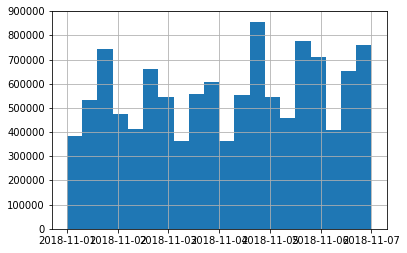

In [58]:
train.ts.hist(bins=20)

In [68]:
(train.ts <= datetime.datetime(2018,11,6)).sum()

9362242

In [69]:
(train.ts > datetime.datetime(2018,11,6)).sum()

2004963

In [71]:
train_sids = train[train.ts <= datetime.datetime(2018,11,6)].session_id.unique()

In [72]:
final.head()

,item_id,appeared,location,price,rel_price_rank,price_mean,price_median,diff_mean,diff_median,diff_mean_rel,...,action_type_click_rel_pos_avg,city_nunique,city_get_first,platform_get_first,device_get_first,nfilters_mean,nfilters_max,nfilters_min,nfilters_get_last,nimps_max
00000510f1adc,2661832,0,0,46,0.60,27.32,20.0,18.68,26.0,0.406087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000510f1adc,9222426,0,1,26,0.76,27.32,20.0,-1.32,6.0,-0.050769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000510f1adc,7051844,0,2,16,0.48,27.32,20.0,-11.32,-4.0,-0.707500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000510f1adc,4079190,0,3,38,0.20,27.32,20.0,10.68,18.0,0.281053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000510f1adc,5752778,0,4,12,0.36,27.32,20.0,-15.32,-8.0,-1.276667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# final.reset_index(name='session_id').head()
xtrain = final[final.index.isin(train_sids)]

In [76]:
xval = final[~final.index.isin(train_sids)]

In [78]:
xtrain.to_hdf('./data/train.h5', key='xtrain', mode='w')

/Users/sam_dessa/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block2_values] [items->['session_id', 'city_get_first', 'platform_get_first', 'device_get_first']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [79]:
xtrain.to_hdf('./data/train.h5', key='xval', mode='a')